In [2]:
import pathlib
import imageio
import numpy as np

# Glob the training data and load a single image path
training_paths = pathlib.Path('../input/stage1_train').glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
im_path = training_sorted[45]
im = imageio.imread(str(im_path))

In [3]:
# Print the image dimensions
print('Original image shape: {}'.format(im.shape))

# Coerce the image into grayscale format (if not already)
from skimage.color import rgb2gray
im_gray = rgb2gray(im)
print('New image shape: {}'.format(im_gray.shape))

Original image shape: (520, 696, 4)
New image shape: (520, 696)


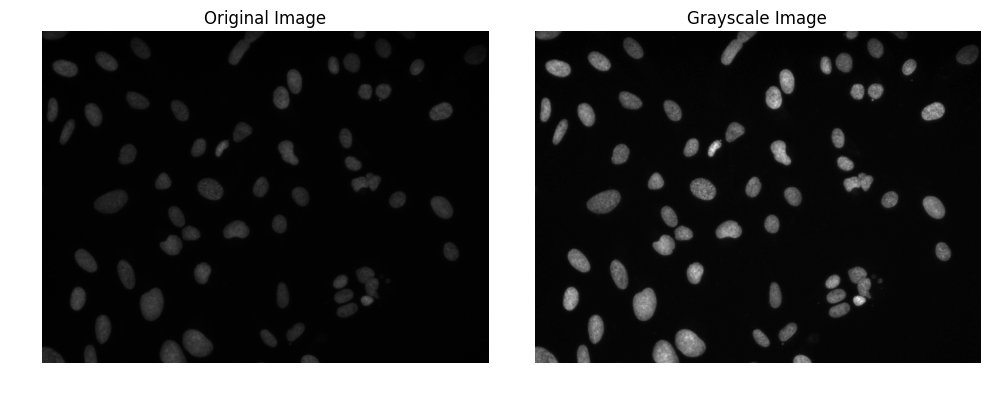

In [4]:
# Now, let's plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(im)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(im_gray, cmap='gray')
plt.axis('off')
plt.title('Grayscale Image')

plt.tight_layout()
plt.show()

In [7]:
print(threshold_otsu.__doc__)

Return threshold value based on Otsu's method.

    Parameters
    ----------
    image : array
        Grayscale input image.
    nbins : int, optional
        Number of bins used to calculate histogram. This value is ignored for
        integer arrays.

    Returns
    -------
    threshold : float
        Upper threshold value. All pixels intensities that less or equal of
        this value assumed as foreground.

    References
    ----------
    .. [1] Wikipedia, http://en.wikipedia.org/wiki/Otsu's_Method

    Examples
    --------
    >>> from skimage.data import camera
    >>> image = camera()
    >>> thresh = threshold_otsu(image)
    >>> binary = image <= thresh

    Notes
    -----
    The input image must be grayscale.
    


In [6]:
from skimage.filters import threshold_otsu
thresh_val = threshold_otsu(im_gray)
mask = np.where(im_gray > thresh_val, 1, 0)

# Make sure the larger portion of the mask is considered background
if np.sum(mask==0) < np.sum(mask==1):
    mask = np.where(mask, 0, 1)

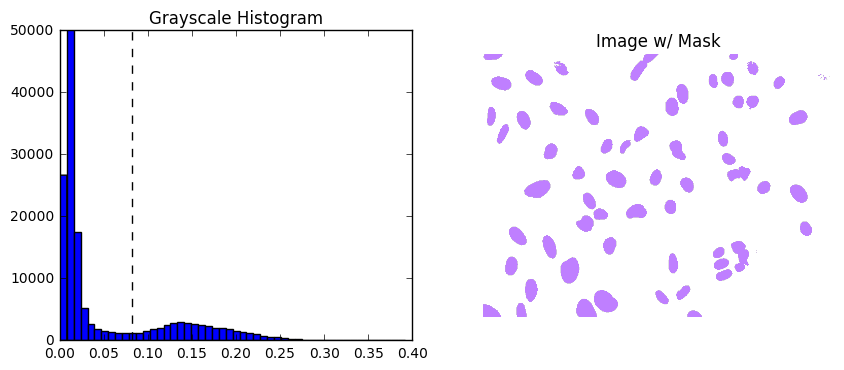

In [6]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
im_pixels = im_gray.flatten()
plt.hist(im_pixels,bins=50)
plt.vlines(thresh_val, 0, 100000, linestyle='--')
plt.ylim([0,50000])
plt.title('Grayscale Histogram')

plt.subplot(1,2,2)
mask_for_display = np.where(mask, mask, np.nan)
# plt.imshow(im_gray, cmap='gray')
plt.imshow(mask_for_display, cmap='rainbow', alpha=0.5)
plt.axis('off')
plt.title('Image w/ Mask')

plt.show()

In [12]:
from scipy import ndimage
labels, nlabels = ndimage.label(mask)
label_arrays = []
for label_num in range(1, nlabels+1):
    label_mask = np.where(labels == label_num, 1, 0)
    label_arrays.append(label_mask)

print('There are {} separate components / objects detected.'.format(nlabels))

There are 76 separate components / objects detected.


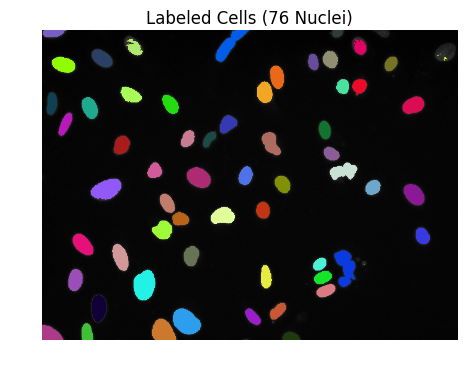

In [8]:
# Create a random colormap
from matplotlib.colors import ListedColormap
rand_cmap = ListedColormap(np.random.rand(256,3))

labels_for_display = np.where(labels > 0, labels, np.nan)
plt.imshow(im_gray, cmap='gray')
plt.imshow(labels_for_display, cmap=rand_cmap)
plt.axis('off')
plt.title('Labeled Cells ({} Nuclei)'.format(nlabels))
plt.show()

In [9]:
for label_ind, label_coords in enumerate(ndimage.find_objects(labels)):
    cell = im_gray[label_coords]
    
    # Check if the label size is too small
    if np.product(cell.shape) < 10: 
        print('Label {} is too small! Setting to 0.'.format(label_ind))
        mask = np.where(labels==label_ind+1, 0, mask)

# Regenerate the labels
labels, nlabels = ndimage.label(mask)
print('There are now {} separate components / objects detected.'.format(nlabels))

Label 4 is too small! Setting to 0.
Label 5 is too small! Setting to 0.
Label 7 is too small! Setting to 0.
Label 8 is too small! Setting to 0.
Label 9 is too small! Setting to 0.
Label 10 is too small! Setting to 0.
Label 14 is too small! Setting to 0.
Label 15 is too small! Setting to 0.
Label 16 is too small! Setting to 0.
Label 19 is too small! Setting to 0.
Label 21 is too small! Setting to 0.
Label 22 is too small! Setting to 0.
Label 23 is too small! Setting to 0.
Label 60 is too small! Setting to 0.
Label 61 is too small! Setting to 0.
Label 72 is too small! Setting to 0.
There are now 60 separate components / objects detected.


In [26]:
two_cell_indices = ndimage.find_objects(labels)[1]
cell_mask = mask[two_cell_indices]
cell_mask_opened = ndimage.binary_opening(cell_mask, iterations=8)

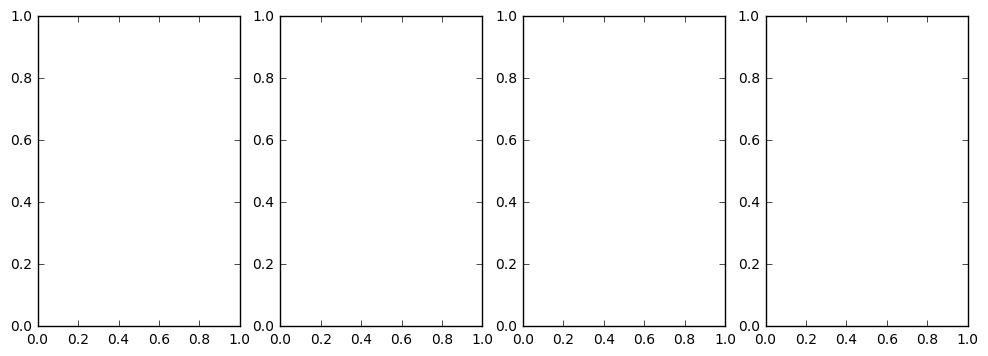

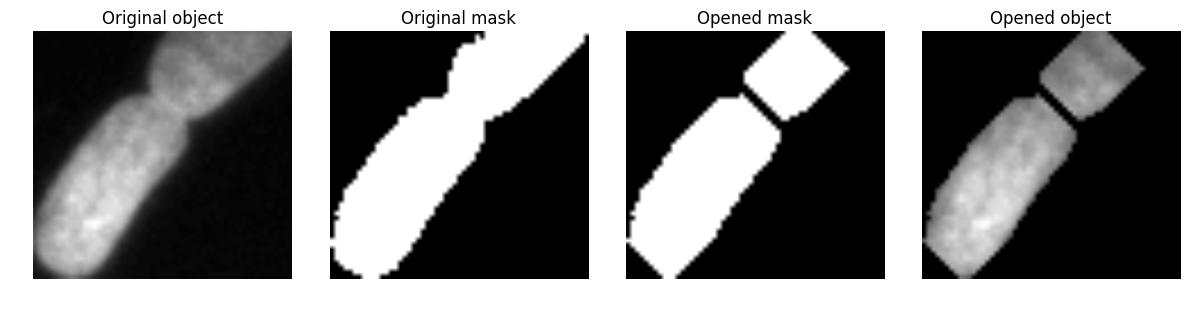

In [27]:
fig, axes = plt.subplots(1,4, figsize=(12,4))

axes[0].imshow(im_gray[two_cell_indices], cmap='gray')
axes[0].set_title('Original object')
axes[1].imshow(mask[two_cell_indices], cmap='gray')
axes[1].set_title('Original mask')
axes[2].imshow(cell_mask_opened, cmap='gray')
axes[2].set_title('Opened mask')
axes[3].imshow(im_gray[two_cell_indices]*cell_mask_opened, cmap='gray')
axes[3].set_title('Opened object')


for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

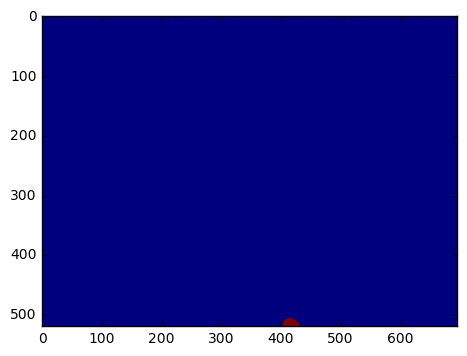

In [28]:
plt.imshow(label_mask)
plt.show()

In [13]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    # from IPython.core.debugger import Tracer; Tracer()()
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

print('RLE Encoding for the current mask is: {}'.format(rle_encoding(label_mask)))

RLE Encoding for the current mask is: 210075 6 210593 8 211112 9 211631 10 212150 11 212669 12 213189 12 213709 12 214228 13 214748 13 215268 13 215788 13 216308 13 216828 13 217348 13 217869 12 218389 12 218909 12 219430 11 219950 11 220471 10 220991 10 221512 9 222033 8 222554 7 223075 6 223596 5 224117 4 224639 2


In [14]:
import pandas as pd

def analyze_image(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = imageio.imread(str(im_path))
    im_gray = rgb2gray(im)
    # from IPython.core.debugger import Tracer; Tracer()()
    
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im_gray)
    mask = np.where(im_gray > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    # from IPython.core.debugger import Tracer; Tracer()()
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image(im_path)
        # from IPython.core.debugger import Tracer; Tracer()()
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [15]:
testing = pathlib.Path('input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images(list(testing))
df.to_csv('submission.csv', index=None)

In [9]:
print(ndimage.binary_opening.__doc__)


    Multi-dimensional binary opening with the given structuring element.

    The *opening* of an input image by a structuring element is the
    *dilation* of the *erosion* of the image by the structuring element.

    Parameters
    ----------
    input : array_like
        Binary array_like to be opened. Non-zero (True) elements form
        the subset to be opened.
    structure : array_like, optional
        Structuring element used for the opening. Non-zero elements are
        considered True. If no structuring element is provided an element
        is generated with a square connectivity equal to one (i.e., only
        nearest neighbors are connected to the center, diagonally-connected
        elements are not considered neighbors).
    iterations : {int, float}, optional
        The erosion step of the opening, then the dilation step are each
        repeated `iterations` times (one, by default). If `iterations` is
        less than 1, each operation is repeated until the re